# API Keys

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

# Time Travel

In [2]:
from langchain_google_genai import ChatGoogleGenerativeAI

# Tools
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.

    Args:
        a: first int
        b: second int
    """

    return a * b

def divide(a: int, b: int) -> float:
    """
    Devide a and b.

    Args:
        a: first int
        b: second int
    """

    return a / b

def sum(a: int, b: int) -> int:
    """
    Sum a and b.

    Args:
        a: first int
        b: second_int
    """

    return a + b

tools = [sum, divide, multiply]

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
llm_with_tools = llm.bind_tools(tools=tools)

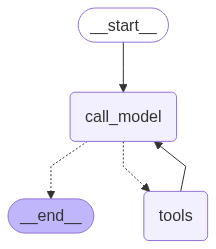

In [3]:
from IPython.display import Image, display

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

# System message
system_message = SystemMessage(content="Your are a helpful assistant tasked with performing arithmatic on a set of inputs.")

# Nodes
def call_model(state: MessagesState) -> MessagesState:
    return {"messages": [llm_with_tools.invoke([system_message] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("tools", ToolNode(tools=tools))

# Logic
builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", tools_condition)
builder.add_edge("tools", "call_model")

# Set up memory
memory = MemorySaver()

# Compile
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [4]:
from random import random

config = {"configurable": {"thread_id": random()}}

input_messages = [HumanMessage(content="Multiply 2 and 3.")]

for event in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (caf26d78-7ebc-4447-9221-429441ee50da)
 Call ID: caf26d78-7ebc-4447-9221-429441ee50da
  Args:
    a: 2.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## Browsing History

In [5]:
state = graph.get_state(config)
print(state)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3.', additional_kwargs={}, response_metadata={}, id='8edb807e-70c4-44ee-9952-342c00561053'), AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 3.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--fc3edc16-ecde-49c7-971c-287023ca6a2b-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2.0, 'b': 3.0}, 'id': 'caf26d78-7ebc-4447-9221-429441ee50da', 'type': 'tool_call'}], usage_metadata={'input_tokens': 171, 'output_tokens': 66, 'total_tokens': 237, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 48}}), ToolMessage(content='6', name='multiply', id='de2b3196-00a8-4dbd-be4c-e17a2adbf1a9', tool_call_id='caf26d78-7ebc-4447-9221-429441ee50da'), AIMessage(content='The result of multiplying 2 and 3 is 6.', additi

In [8]:
all_states = list(graph.get_state_history(config))

In [9]:
len(all_states)

5

In [ ]:
# First state
all_states[-1]

# Last state
all_states[0]

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '0.12058398909580059', 'checkpoint_ns': '', 'checkpoint_id': '1f072ec7-1256-629b-bfff-4619ac73ea20'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-08-06T17:40:28.460908+00:00', parent_config=None, tasks=(PregelTask(id='b0e3bcb3-251a-7049-5714-14c68d4a3d87', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'messages': [HumanMessage(content='Multiply 2 and 3.', additional_kwargs={}, response_metadata={}, id='8edb807e-70c4-44ee-9952-342c00561053')]}),), interrupts=())

In [12]:
to_replay = all_states[-2]

In [13]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3.', additional_kwargs={}, response_metadata={}, id='8edb807e-70c4-44ee-9952-342c00561053')]}

In [14]:
to_replay.next

('call_model',)

In [15]:
to_replay.config

{'configurable': {'thread_id': '0.12058398909580059',
  'checkpoint_ns': '',
  'checkpoint_id': '1f072ec7-1258-658e-8000-cf978c4d0cff'}}

## Forking

In [16]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3.', additional_kwargs={}, response_metadata={}, id='8edb807e-70c4-44ee-9952-342c00561053')]

In [17]:
to_fork.config

{'configurable': {'thread_id': '0.12058398909580059',
  'checkpoint_ns': '',
  'checkpoint_id': '1f072ec7-1258-658e-8000-cf978c4d0cff'}}

In [18]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content="Multiply 5 and 3.", id=to_fork.values["messages"][0].id)]}
)

In [19]:
fork_config

{'configurable': {'thread_id': '0.12058398909580059',
  'checkpoint_ns': '',
  'checkpoint_id': '1f072f00-2b34-61bd-8001-fbca781520fe'}}

In [22]:
all_states = list(graph.get_state_history(config))
len(all_states)

6

In [23]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3.
================================== Ai Message ==================================
Tool Calls:
  multiply (3ff23d67-b0c1-4efd-8f3f-caf86dbacb69)
 Call ID: 3ff23d67-b0c1-4efd-8f3f-caf86dbacb69
  Args:
    a: 5.0
    b: 3.0
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.
